In [1]:
from __future__ import print_function
import numpy as np
import imageio
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing

In [2]:
####################        Test if an GPU is available     #################################
if torch.cuda.is_available():     
    print('used GPU: ' + torch.cuda.get_device_name(0))
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
    
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

used GPU: GeForce GTX 1050 Ti


In [3]:
####################        Predefine some Variables        #################################
dataDir = '../../resized'                                                      # path to directory of medical MNIST images

numEpochs = 10                                                              # number of epochs
batchSize = 300                                                             # size of batches

t2vRatio = 1.2                                                              # Maximum allowed ratio of validation to training loss
t2vEpochs = 3                                                               # Number of consecutive epochs before halting if validation loss exceeds above limit

running_loss = 0.0                                                          # running loss
lRate = 0.001                                                               # learning rate of classifier
momentum = 0.9                                                              # adds a proportion of the previous weight changes to the current weight changes

sameClassOcc = True                                                         # Every Class has same count of images in test and training set
testSize = 0.8                                                              # fraction of images for test dataset

numConvs1   = 5                                                             # number of channels produced by the convolution
convSize1   = 7                                                             # size of the convolving kernel
numConvs2   = 10                                                            # number of channels produced by the convolution
convSize2   = 7                                                             # size of the convolving kernel

fcSize1 = 400                                                               # size of sample
fcSize2 = 80                                                                # size of sample

validList = []                                                              # list for valid data
testList = []                                                               # list for test data
trainList = []                                                              # list for train data


In [4]:
####################        Read and Prepare Images         #################################
classNames = os.listdir(dataDir)                                            # Each type of image can be found in its own subdirectory
numClass = len(classNames)                                                  # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
            for i in range(numClass)]                                       # nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]                     # count of each type of image
imageFilesList = []                                                         # un-nested list of filenames
imageClass = []                                                             # The labels -- the type of each individual image in the list
if sameClassOcc == True:
    for i in range(numClass):
        imageFilesList.extend(imageFiles[i][:np.min(numEach)])
        imageClass.extend([i]*np.min(numEach))
else:
    for i in range(numClass):
        imageFilesList.extend(imageFiles[i])
        imageClass.extend([i]*numEach[i])

numTotal = len(imageClass)                                                  # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size                # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 53724 images in 6 distinct categories
Label names: ['HeadCT', 'AbdomenCT', 'BreastMRI', 'Hand', 'ChestCT', 'CXR']
Label counts: [10000, 10000, 8954, 10000, 10000, 10000]
Image dimensions: 64 x 64


In [5]:
####################        Store and Rescale Images               #################################
toTensor = torchvision.transforms.ToTensor()
def scaleImage(x):                                                          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):                                                  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()                                                        # Subtract the mean value of the image
    return z

imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Create image (X) tensor
classTensor = torch.tensor(imageClass)                                          # Create label (Y) tensor  
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
        .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.774; Max = 0.972; Mean = -2.9e-09


In [6]:
####################        Seperate DataSet to Train/Test          #################################
x_train, x_test, y_train, y_test = train_test_split(imageTensor, classTensor, test_size=testSize, random_state=4, shuffle=True, stratify=classTensor)

for i in range(numClass):
    print(sum(y_train==i))

tensor(1791)
tensor(1790)
tensor(1790)
tensor(1791)
tensor(1791)
tensor(1791)


In [7]:
####################        Define the teacher neural network       #################################
class Net(nn.Module):
    def __init__(self,xDim,yDim,numC):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1,numConvs1,convSize1)                       # first convolutional layer
        #self.pool = nn.MaxPool2d(2,2)                                      # max pooling layer
        self.conv2 = nn.Conv2d(numConvs1,numConvs2, convSize2)              # second convolutional layer

        self.fc1 = nn.Linear(numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1)), fcSize1)    # first fully connected layer
        self.fc2 = nn.Linear(fcSize1,fcSize2)                               # second fully connected layer
        self.fc3 = nn.Linear(fcSize2,numClass)                              # third fully connected layer

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))                              # first conv layer with relu activation function
        # x = self.pool(F.relu(self.conv2(x)))                              # second conv layer with relu activation function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))                                             # first fc layer with relu activation function
        x = F.relu(self.fc2(x))                                             # second fc layer with relu activation function
        x = self.fc3(x)                                                     # output layer
        return x

    def num_flat_features(self, x):                                         # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [8]:
teachernet = Net(imageWidth,imageHeight,numClass).cuda()                           # create neural network
criterion = nn.CrossEntropyLoss()                                           # set criterion
optimizer = optim.SGD(teachernet.parameters(), lr=lRate, momentum=momentum)        # set optimizer to squared gradient decent

trainBats = x_train.size()[0] // batchSize                                             # Number of training batches per epoch. Round down to simplify last batch
testBats = -(-x_test.size()[0] // batchSize)                                           # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)                                           # This takes into account the imbalanced dataset.

In [9]:
####################        Training the teacher neural network       #################################
for epoch in range(numEpochs):
    epochLoss = 0
    # X is a torch Variable
    permutation = torch.randperm(x_train.size()[0])

    for i in range(0,x_train.size()[0], batchSize):
        optimizer.zero_grad()

        indices = permutation[i:i+batchSize]
        batch_x, batch_y = x_train[indices], y_train[indices]

        # in case you wanted a semi-full example
        outputs = teachernet.forward(batch_x.to(dev))
        loss = F.cross_entropy(outputs,batch_y.to(dev))
        epochLoss += loss.item()                                            # Add loss
        
        loss.backward()
        optimizer.step()


    # print statistics
    running_loss += loss.item()
    print("Epoch = {:-3}; Training loss = {:.4f}".format(epoch,epochLoss))

print('Finished Training')

Epoch =   0; Training loss = 64.5297
Epoch =   1; Training loss = 64.3366
Epoch =   2; Training loss = 63.9879
Epoch =   3; Training loss = 62.9994
Epoch =   4; Training loss = 57.0749
Epoch =   5; Training loss = 28.8529
Epoch =   6; Training loss = 13.4080
Epoch =   7; Training loss = 9.7913
Epoch =   8; Training loss = 8.4059
Epoch =   9; Training loss = 7.4710
Finished Training


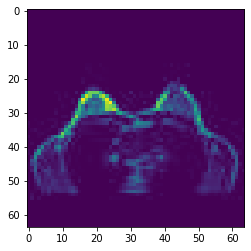

In [10]:
np.shape(x_test[1][0].reshape(1,1,64,64))
plt.imshow((x_test[1]).reshape(64,64))

In [12]:
####################        Evaluate the teacher neural network       #################################
confuseMtx = np.zeros((numClass,numClass),dtype=int)
evalMat = []
pseudoX = []
pseudoY = []
pseudoX_test = []
pseudoY_test = []
counter = 0
for j in range(len(x_test)):
    pred = teachernet(x_test[j].reshape(1,1,imageWidth,imageHeight).to(dev))
    
    # Is-Class - Predicted-CLass - Prediction-Value
    evalMat.append([int(y_test[j].cpu().numpy()), pred.max(1)[1].cpu().numpy()[0], pred.max(1)[0].cpu().detach().numpy()[0]])
    confuseMtx[int(y_test[j].cpu().numpy()),pred.max(1)[1].cpu().numpy()[0]] += 1

    if pred.max(1)[0].cpu().detach().numpy()[0] >= 12.0:
        print(str(counter) + ": "+ str(pred.max(1)[0].cpu().detach().numpy()[0]))
        pseudoX.append(x_test[j].numpy())
        pseudoY.append(pred.max(1)[1].cpu().numpy()[0])
        counter += 1
        # Is-Class - Predicted-CLass - Prediction-Value
        #evalMat.append([int(y_test[j].cpu().numpy()), pred.max(1)[1].cpu().numpy()[0], pred.max(1)[0].cpu().detach().numpy()[0]])
        #confuseMtx[int(y_test[j].cpu().numpy()),pred.max(1)[1].cpu().numpy()[0]] += 1
    else:
        pseudoX_test.append(x_test[j].numpy())
        pseudoY_test.append(y_test[j])
    
pseudoX_test = torch.tensor(pseudoX_test)
pseudoY_test = torch.LongTensor(pseudoY_test)
pseudoX_train = torch.cat((x_train, torch.Tensor(pseudoX)), 0)
pseudoY_train = torch.cat((y_train, torch.LongTensor(pseudoY)), 0)
#print(confuseMtx)
#print(evalMat)

0: 13.358739
1: 15.616899
2: 14.302823
3: 13.613946
4: 15.4581
5: 12.881545
6: 17.495998
7: 13.331437
8: 12.875332
9: 15.033332
10: 14.881106
11: 16.967295
12: 14.438801
13: 17.312372
14: 12.107751
15: 12.313103
16: 13.879545
17: 12.912006
18: 13.892512
19: 16.264143
20: 13.034057
21: 12.58774
22: 12.327178
23: 13.940466
24: 16.325947
25: 13.118688
26: 14.097682
27: 14.31745
28: 15.386149
29: 13.215392
30: 12.468912
31: 14.241419
32: 13.156532
33: 19.864202
34: 12.395297
35: 14.733438
36: 14.319352
37: 13.082708
38: 14.449934
39: 14.094195
40: 13.932655
41: 13.367239
42: 13.985133
43: 15.764799
44: 12.338402
45: 16.040987
46: 16.252457
47: 14.921273
48: 12.073072
49: 12.827775
50: 13.713862
51: 13.143797
52: 14.113625
53: 13.112388
54: 12.445424
55: 17.039942
56: 14.105912
57: 15.727951
58: 13.63894
59: 16.287457
60: 19.024435
61: 14.920194
62: 16.83301
63: 14.453547
64: 13.421281
65: 14.025836
66: 13.512005
67: 13.94399
68: 14.472168
69: 13.258382
70: 13.001848
71: 14.031457
72: 14.81

588: 13.792145
589: 15.572372
590: 14.277631
591: 14.928317
592: 15.8418
593: 15.197993
594: 12.607363
595: 13.836255
596: 13.381002
597: 13.301934
598: 12.080893
599: 14.792613
600: 16.557405
601: 12.385478
602: 15.284489
603: 15.358108
604: 17.331743
605: 12.188713
606: 13.034898
607: 16.576141
608: 13.772611
609: 12.991411
610: 12.320798
611: 13.762665
612: 15.7594385
613: 12.503134
614: 14.345693
615: 13.581407
616: 12.006245
617: 13.28467
618: 12.345466
619: 13.708968
620: 14.740106
621: 13.365576
622: 14.583777
623: 13.61402
624: 12.541021
625: 13.789448
626: 14.181398
627: 15.349462
628: 12.975157
629: 15.529294
630: 17.248001
631: 14.675823
632: 13.961682
633: 13.129656
634: 12.338372
635: 12.617086
636: 14.077446
637: 13.571958
638: 16.38915
639: 13.730727
640: 13.65109
641: 12.012671
642: 12.636224
643: 14.161107
644: 13.887119
645: 13.1590395
646: 13.268794
647: 14.435798
648: 12.516033
649: 14.957254
650: 13.746372
651: 17.696983
652: 15.011384
653: 16.264175
654: 12.392523

1147: 14.070228
1148: 12.680602
1149: 14.592107
1150: 19.583027
1151: 13.963275
1152: 16.073683
1153: 13.724302
1154: 16.494844
1155: 14.748327
1156: 15.052513
1157: 12.426502
1158: 13.745776
1159: 17.85465
1160: 12.720531
1161: 12.915587
1162: 13.434639
1163: 12.794073
1164: 13.414023
1165: 16.911366
1166: 16.123241
1167: 12.049012
1168: 15.34125
1169: 16.642546
1170: 12.85019
1171: 12.806391
1172: 14.056522
1173: 13.845997
1174: 14.104114
1175: 12.096168
1176: 12.804738
1177: 13.878598
1178: 16.364819
1179: 13.203737
1180: 12.046265
1181: 14.463004
1182: 15.602251
1183: 13.1198845
1184: 15.607001
1185: 12.808767
1186: 13.553274
1187: 13.143446
1188: 13.31097
1189: 18.680267
1190: 16.938066
1191: 16.836304
1192: 14.743808
1193: 13.6372175
1194: 13.658961
1195: 13.79684
1196: 12.504258
1197: 13.029122
1198: 14.020729
1199: 14.180793
1200: 16.184328
1201: 12.850673
1202: 13.53047
1203: 12.519277
1204: 16.277424
1205: 12.722811
1206: 14.177556
1207: 15.901206
1208: 12.600494
1209: 14.108

1674: 13.049554
1675: 12.435597
1676: 13.091975
1677: 13.753581
1678: 12.474663
1679: 12.435933
1680: 12.016895
1681: 14.25803
1682: 16.743635
1683: 13.34327
1684: 12.679578
1685: 12.600866
1686: 15.640028
1687: 14.982943
1688: 15.446652
1689: 13.570382
1690: 13.514098
1691: 14.00505
1692: 17.097626
1693: 12.826216
1694: 16.05348
1695: 14.461225
1696: 12.831946
1697: 13.770568
1698: 13.547009
1699: 15.384878
1700: 13.78779
1701: 12.572364
1702: 13.994879
1703: 15.18453
1704: 18.097227
1705: 14.061763
1706: 17.271198
1707: 15.054629
1708: 13.619018
1709: 13.236881
1710: 13.75394
1711: 14.127649
1712: 12.659701
1713: 12.30733
1714: 14.034783
1715: 15.183697
1716: 13.288808
1717: 12.534007
1718: 12.295825
1719: 15.043755
1720: 15.393427
1721: 15.314258
1722: 16.026691
1723: 13.25258
1724: 13.613326
1725: 14.314978
1726: 16.49104
1727: 13.156747
1728: 12.3485565
1729: 12.87484
1730: 16.793781
1731: 13.215574
1732: 14.954321
1733: 14.182267
1734: 13.420743
1735: 13.76293
1736: 13.181773
173

2194: 13.178208
2195: 14.726406
2196: 12.053288
2197: 12.637732
2198: 15.57771
2199: 13.275889
2200: 12.084554
2201: 18.752106
2202: 16.808453
2203: 12.523642
2204: 14.847672
2205: 13.98452
2206: 12.150121
2207: 16.741531
2208: 17.35237
2209: 12.318203
2210: 13.470718
2211: 12.81928
2212: 14.057714
2213: 16.22594
2214: 13.433369
2215: 12.729971
2216: 12.828899
2217: 12.569449
2218: 12.305636
2219: 12.370342
2220: 13.286452
2221: 16.793268
2222: 14.871999
2223: 13.792981
2224: 14.710361
2225: 13.907502
2226: 15.769724
2227: 18.32665
2228: 13.942626
2229: 13.546418
2230: 12.020747
2231: 16.39872
2232: 17.767178
2233: 14.060987
2234: 16.957386
2235: 12.318471
2236: 12.903657
2237: 13.859796
2238: 12.76784
2239: 16.19581
2240: 13.674311
2241: 14.381306
2242: 12.521716
2243: 12.684096
2244: 12.089557
2245: 16.92407
2246: 12.982335
2247: 15.110555
2248: 13.970513
2249: 16.237667
2250: 12.606443
2251: 13.007822
2252: 13.1981
2253: 14.714268
2254: 12.733545
2255: 12.724994
2256: 13.890114
2257

2741: 14.273271
2742: 12.398348
2743: 12.89606
2744: 12.136298
2745: 13.722726
2746: 12.013403
2747: 13.291454
2748: 13.213764
2749: 13.131946
2750: 13.371436
2751: 13.463326
2752: 15.736681
2753: 13.632829
2754: 14.673495
2755: 12.768874
2756: 13.49505
2757: 14.465693
2758: 12.896202
2759: 12.203778
2760: 16.339737
2761: 13.3122015
2762: 13.695701
2763: 13.637812
2764: 14.847699
2765: 12.569269
2766: 14.032319
2767: 18.403353
2768: 15.237718
2769: 13.777406
2770: 12.510453
2771: 13.502492
2772: 12.523169
2773: 13.736754
2774: 12.375714
2775: 15.738123
2776: 12.988298
2777: 13.048303
2778: 14.034611
2779: 13.641481
2780: 12.303353
2781: 16.143034
2782: 13.191172
2783: 13.740305
2784: 13.307102
2785: 13.256189
2786: 12.185048
2787: 14.573939
2788: 12.896634
2789: 15.931253
2790: 12.42056
2791: 12.032721
2792: 12.396855
2793: 13.378448
2794: 14.531245
2795: 19.23602
2796: 14.234273
2797: 12.769503
2798: 12.388744
2799: 14.850974
2800: 13.110427
2801: 17.58029
2802: 14.157816
2803: 17.309

3263: 14.686723
3264: 17.321444
3265: 19.497475
3266: 14.360927
3267: 12.332458
3268: 12.395469
3269: 14.086864
3270: 15.494893
3271: 16.242315
3272: 13.261513
3273: 17.339224
3274: 13.670333
3275: 15.793861
3276: 15.454047
3277: 16.06113
3278: 13.574117
3279: 18.50003
3280: 14.090256
3281: 12.601831
3282: 14.566295
3283: 14.716509
3284: 15.715722
3285: 15.4827
3286: 15.51261
3287: 14.3164
3288: 14.59609
3289: 12.296208
3290: 17.538935
3291: 15.555673
3292: 12.842189
3293: 15.450308
3294: 13.456724
3295: 12.222188
3296: 12.420796
3297: 12.401289
3298: 13.259389
3299: 16.497606
3300: 14.31096
3301: 13.871234
3302: 12.324281
3303: 19.339468
3304: 14.725638
3305: 12.67627
3306: 12.391157
3307: 12.937871
3308: 14.20307
3309: 15.7405205
3310: 12.67391
3311: 13.236882
3312: 14.199668
3313: 14.163635
3314: 13.367157
3315: 12.976311
3316: 14.604244
3317: 14.2066
3318: 13.809661
3319: 15.4147
3320: 16.811106
3321: 16.240343
3322: 14.067185
3323: 14.255688
3324: 13.600289
3325: 18.26088
3326: 12

3784: 12.915724
3785: 14.495693
3786: 13.612313
3787: 16.027807
3788: 12.712201
3789: 13.104031
3790: 14.448588
3791: 13.68588
3792: 15.660289
3793: 13.879487
3794: 12.034753
3795: 12.511381
3796: 14.080509
3797: 13.327447
3798: 12.530281
3799: 14.981162
3800: 12.042669
3801: 13.5966215
3802: 12.625356
3803: 14.05989
3804: 13.376059
3805: 12.605388
3806: 12.735377
3807: 13.123719
3808: 13.353733
3809: 13.717716
3810: 12.154983
3811: 13.47609
3812: 14.052094
3813: 13.450936
3814: 13.020651
3815: 12.13803
3816: 15.08975
3817: 13.820312
3818: 13.9044895
3819: 14.045766
3820: 13.120862
3821: 13.486143
3822: 12.113115
3823: 13.513998
3824: 15.367512
3825: 12.648534
3826: 15.637847
3827: 14.187843
3828: 18.549982
3829: 12.015173
3830: 13.612181
3831: 12.943125
3832: 12.413964
3833: 12.096337
3834: 12.02109
3835: 12.240188
3836: 14.787725
3837: 16.30589
3838: 13.468232
3839: 12.637094
3840: 13.067682
3841: 13.212197
3842: 13.533855
3843: 15.524761
3844: 13.365485
3845: 13.377431
3846: 16.7832

4307: 15.472167
4308: 13.294953
4309: 12.190034
4310: 14.41779
4311: 14.758742
4312: 13.214534
4313: 13.217948
4314: 12.516339
4315: 14.748459
4316: 12.116326
4317: 14.425044
4318: 15.63164
4319: 14.341157
4320: 12.087575
4321: 13.267273
4322: 14.262833
4323: 15.297535
4324: 13.431398
4325: 14.1228485
4326: 12.770144
4327: 14.023797
4328: 12.63528
4329: 13.234901
4330: 13.222217
4331: 12.837751
4332: 12.407884
4333: 13.327214
4334: 13.42458
4335: 15.062967
4336: 13.901843
4337: 12.247943
4338: 13.992272
4339: 13.044074
4340: 13.105489
4341: 16.281763
4342: 12.073087
4343: 14.331958
4344: 12.571143
4345: 12.556712
4346: 17.277472
4347: 12.208743
4348: 15.284982
4349: 12.839894
4350: 13.363376
4351: 17.024511
4352: 13.621894
4353: 14.232338
4354: 13.796399
4355: 13.343601
4356: 17.1349
4357: 13.117616
4358: 17.873856
4359: 15.399266
4360: 12.405909
4361: 14.548291
4362: 13.410961
4363: 14.310283
4364: 13.768963
4365: 16.643644
4366: 13.963416
4367: 13.343793
4368: 12.6581545
4369: 13.534

4827: 12.557674
4828: 14.217269
4829: 12.783426
4830: 13.427349
4831: 15.305392
4832: 12.019842
4833: 13.060496
4834: 14.601659
4835: 15.820193
4836: 12.172158
4837: 14.58846
4838: 13.170971
4839: 16.98818
4840: 15.199538
4841: 14.167306
4842: 14.084347
4843: 12.068952
4844: 15.146554
4845: 15.169965
4846: 13.749437
4847: 12.425887
4848: 17.16744
4849: 13.959138
4850: 14.435888
4851: 13.389682
4852: 13.489025
4853: 13.678908
4854: 12.825439
4855: 12.880757
4856: 13.633606
4857: 14.203955
4858: 16.632755
4859: 12.255808
4860: 16.681004
4861: 13.742806
4862: 12.272489
4863: 13.760464
4864: 12.38984
4865: 12.169215
4866: 13.799809
4867: 14.813042
4868: 13.656039
4869: 13.312586
4870: 16.648567
4871: 12.570699
4872: 13.876478
4873: 14.814428
4874: 13.856748
4875: 12.340815
4876: 17.88397
4877: 14.105543
4878: 13.470672
4879: 17.184338
4880: 13.514039
4881: 12.852416
4882: 13.125082
4883: 12.992288
4884: 17.216288
4885: 14.274667
4886: 15.166987
4887: 13.439846
4888: 13.041557
4889: 13.3655

5376: 12.283966
5377: 14.792409
5378: 12.699027
5379: 14.360322
5380: 12.6208315
5381: 15.874928
5382: 12.102012
5383: 12.256035
5384: 13.994693
5385: 13.0747385
5386: 12.79709
5387: 13.127738
5388: 12.375659
5389: 13.612085
5390: 14.789336
5391: 14.455791
5392: 14.073193
5393: 13.159413
5394: 14.37137
5395: 17.067636
5396: 14.239347
5397: 15.550936
5398: 13.591546
5399: 14.209094
5400: 13.612012
5401: 12.752417
5402: 14.986912
5403: 15.876172
5404: 15.6311035
5405: 12.877986
5406: 15.937921
5407: 13.623553
5408: 13.9606
5409: 14.032348
5410: 14.115099
5411: 12.807927
5412: 13.8657255
5413: 12.187444
5414: 13.71857
5415: 14.319766
5416: 16.805496
5417: 14.848783
5418: 12.934301
5419: 13.336261
5420: 14.064303
5421: 14.108567
5422: 14.07776
5423: 15.60328
5424: 12.697314
5425: 12.632509
5426: 13.725219
5427: 14.276488
5428: 12.274419
5429: 17.326466
5430: 18.69616
5431: 13.008461
5432: 13.501659
5433: 16.256895
5434: 13.066028
5435: 12.455365
5436: 12.7326145
5437: 12.30781
5438: 14.268

5906: 12.774909
5907: 14.026897
5908: 12.616242
5909: 13.8629
5910: 13.518703
5911: 14.48065
5912: 12.349502
5913: 14.834594
5914: 12.659995
5915: 14.081249
5916: 13.0495615
5917: 13.32945
5918: 13.013994
5919: 12.508011
5920: 14.857822
5921: 17.014887
5922: 12.877988
5923: 12.428029
5924: 15.953776
5925: 14.054963
5926: 12.020037
5927: 16.98553
5928: 13.15033
5929: 13.681258
5930: 12.108096
5931: 13.474053
5932: 15.304988
5933: 13.399789
5934: 13.59689
5935: 13.426665
5936: 15.647605
5937: 15.788197
5938: 13.628522
5939: 15.061009
5940: 14.101869
5941: 12.81294
5942: 12.678539
5943: 13.705908
5944: 13.588414
5945: 14.105294
5946: 18.023628
5947: 12.93314
5948: 12.913409
5949: 12.554475
5950: 14.58772
5951: 12.65617
5952: 12.353059
5953: 13.239393
5954: 13.153657
5955: 12.9609375
5956: 12.204449
5957: 13.41555
5958: 16.40782
5959: 12.479662
5960: 12.263308
5961: 13.295551
5962: 14.362359
5963: 12.417741
5964: 12.133887
5965: 13.602636
5966: 12.05589
5967: 14.923637
5968: 12.419479
5969

6437: 13.476865
6438: 13.728863
6439: 16.146511
6440: 14.652063
6441: 17.386011
6442: 14.412423
6443: 14.164474
6444: 12.79428
6445: 15.998105
6446: 16.573
6447: 14.72852
6448: 15.148922
6449: 14.197978
6450: 13.385794
6451: 14.046232
6452: 16.187809
6453: 13.670678
6454: 15.589472
6455: 12.33126
6456: 14.455817
6457: 13.021385
6458: 13.727929
6459: 13.765055
6460: 13.886396
6461: 12.532428
6462: 12.422406
6463: 14.044205
6464: 13.776875
6465: 18.054262
6466: 19.044542
6467: 13.821975
6468: 13.137048
6469: 12.680078
6470: 16.464573
6471: 13.324228
6472: 12.764143
6473: 15.1870165
6474: 12.075239
6475: 16.365704
6476: 15.547854
6477: 14.506436
6478: 12.687676
6479: 13.637269
6480: 12.988991
6481: 14.242059
6482: 13.0784235
6483: 12.89192
6484: 13.271658
6485: 13.893586
6486: 12.514622
6487: 14.823689
6488: 12.918161
6489: 14.001922
6490: 14.25836
6491: 13.006511
6492: 12.500608
6493: 12.41098
6494: 13.331289
6495: 15.432597
6496: 13.979811
6497: 13.797992
6498: 16.239012
6499: 16.231276

6980: 14.374955
6981: 12.42507
6982: 13.265327
6983: 13.045
6984: 16.261051
6985: 13.693808
6986: 15.439049
6987: 13.81078
6988: 13.809846
6989: 13.998565
6990: 13.4754925
6991: 18.441254
6992: 13.994058
6993: 14.702307
6994: 13.530645
6995: 15.453793
6996: 12.574605
6997: 13.28345
6998: 15.15014
6999: 12.831922
7000: 13.999912
7001: 13.44925
7002: 13.679017
7003: 14.485295
7004: 13.00318
7005: 16.124434
7006: 15.053686
7007: 13.937097
7008: 16.560425
7009: 13.896262
7010: 13.673135
7011: 17.368166
7012: 12.018202
7013: 12.577325
7014: 14.15812
7015: 14.054568
7016: 12.163651
7017: 13.525928
7018: 14.7735815
7019: 13.944688
7020: 12.211653
7021: 17.003742
7022: 14.330508
7023: 12.136754
7024: 12.022093
7025: 14.192568
7026: 13.920694
7027: 17.013021
7028: 15.889326
7029: 17.395752
7030: 12.164192
7031: 14.30511
7032: 15.948598
7033: 13.435679
7034: 13.676991
7035: 13.693365
7036: 14.701189
7037: 13.253813
7038: 13.26471
7039: 13.371285
7040: 13.308047
7041: 13.189055
7042: 12.689234
70

7503: 14.054437
7504: 14.135731
7505: 13.532553
7506: 17.13905
7507: 12.916648
7508: 12.79322
7509: 14.680182
7510: 12.333739
7511: 13.427795
7512: 13.712755
7513: 15.8833065
7514: 12.63676
7515: 14.595092
7516: 14.671714
7517: 12.321385
7518: 12.965142
7519: 12.824731
7520: 15.73915
7521: 12.460307
7522: 14.07346
7523: 12.39032
7524: 13.787099
7525: 13.954439
7526: 14.691582
7527: 12.470271
7528: 15.061196
7529: 13.573191
7530: 14.60746
7531: 14.744329
7532: 12.993944
7533: 14.006322
7534: 15.722606
7535: 13.127025
7536: 15.297195
7537: 13.275243
7538: 13.521382
7539: 14.527142
7540: 12.483653
7541: 12.558369
7542: 12.208837
7543: 14.992345
7544: 16.745062
7545: 12.949042
7546: 16.253136
7547: 12.944465
7548: 13.098142
7549: 14.362065
7550: 12.453528
7551: 13.211916
7552: 14.083329
7553: 13.391056
7554: 15.278785
7555: 12.7764845
7556: 12.020797
7557: 15.675691
7558: 12.819675
7559: 13.504155
7560: 12.667928
7561: 18.083563
7562: 13.7607975
7563: 12.752938
7564: 16.292316
7565: 14.659

8029: 13.607888
8030: 13.595029
8031: 12.676046
8032: 14.19942
8033: 12.370058
8034: 12.55966
8035: 13.173188
8036: 13.930461
8037: 15.277555
8038: 16.348883
8039: 12.42482
8040: 14.072629
8041: 13.289524
8042: 15.8695965
8043: 14.972203
8044: 14.939165
8045: 14.136775
8046: 16.016266
8047: 12.43902
8048: 17.5179
8049: 14.953549
8050: 16.2256
8051: 14.827087
8052: 13.221118
8053: 13.870723
8054: 13.099181
8055: 15.331172
8056: 14.878109
8057: 12.120621
8058: 12.864379
8059: 14.860753
8060: 16.007738
8061: 14.676807
8062: 13.5702
8063: 14.279877
8064: 16.66021
8065: 14.522576
8066: 16.953636
8067: 13.72388
8068: 13.422929
8069: 15.401028
8070: 16.039196
8071: 13.937938
8072: 13.005986
8073: 13.9510765
8074: 13.831842
8075: 15.082694
8076: 12.996904
8077: 16.364346
8078: 12.251076
8079: 13.856376
8080: 14.555973
8081: 15.906607
8082: 12.557147
8083: 14.357794
8084: 16.215937
8085: 14.168621
8086: 15.375753
8087: 12.511877
8088: 12.6098385
8089: 17.015612
8090: 12.993423
8091: 12.607996
8

8572: 12.706079
8573: 16.548223
8574: 14.165835
8575: 14.173428
8576: 19.196041
8577: 12.850356
8578: 12.80164
8579: 12.680486
8580: 14.559214
8581: 12.773075
8582: 13.188647
8583: 12.88437
8584: 13.263483
8585: 15.252948
8586: 13.2308035
8587: 13.825168
8588: 13.825569
8589: 14.291106
8590: 14.592008
8591: 16.820665
8592: 13.163606
8593: 12.485708
8594: 16.3921
8595: 14.723511
8596: 13.672293
8597: 14.765958
8598: 13.69744
8599: 12.954172
8600: 13.6093645
8601: 13.627311
8602: 13.723177
8603: 14.223176
8604: 12.013486
8605: 14.855227
8606: 12.329298
8607: 14.847621
8608: 15.706745
8609: 15.147116
8610: 12.967342
8611: 15.276693
8612: 18.206778
8613: 12.023351
8614: 16.37727
8615: 12.607322
8616: 15.561712
8617: 16.527372
8618: 14.570434
8619: 16.362823
8620: 14.468964
8621: 16.273415
8622: 14.562354
8623: 16.027649
8624: 12.308862
8625: 13.310975
8626: 14.647542
8627: 13.53131
8628: 12.09971
8629: 16.64763
8630: 14.147197
8631: 13.697174
8632: 14.110324
8633: 12.296775
8634: 15.542679

9108: 13.354959
9109: 13.471344
9110: 13.332446
9111: 12.761212
9112: 12.229518
9113: 12.203851
9114: 14.708082
9115: 15.680459
9116: 14.066872
9117: 14.500535
9118: 13.051769
9119: 16.254807
9120: 13.477587
9121: 12.736526
9122: 18.136719
9123: 13.150261
9124: 17.383116
9125: 12.314914
9126: 14.478776
9127: 15.010868
9128: 14.844774
9129: 15.785116
9130: 12.092012
9131: 18.021187
9132: 15.707245
9133: 12.504859
9134: 12.317894
9135: 14.650838
9136: 15.487831
9137: 13.693397
9138: 12.640104
9139: 13.003757
9140: 15.466511
9141: 12.95113
9142: 13.928265
9143: 12.063622
9144: 15.824471
9145: 12.689099
9146: 12.081
9147: 14.51769
9148: 16.509632
9149: 15.211327
9150: 15.5765915
9151: 12.814857
9152: 15.559091
9153: 13.069079
9154: 12.885861
9155: 14.199692
9156: 14.059399
9157: 15.311982
9158: 13.619236
9159: 13.35303
9160: 17.019114
9161: 14.909053
9162: 13.3448515
9163: 13.918578
9164: 12.729779
9165: 14.351712
9166: 13.787486
9167: 12.0396595
9168: 13.07376
9169: 13.786108
9170: 13.562

9651: 16.437923
9652: 13.192136
9653: 13.320208
9654: 12.404313
9655: 16.380713
9656: 15.846003
9657: 12.342665
9658: 14.404302
9659: 13.033305
9660: 17.217289
9661: 13.354235
9662: 18.688725
9663: 16.523336
9664: 15.377347
9665: 18.086748
9666: 12.023405
9667: 13.808816
9668: 14.541558
9669: 18.06298
9670: 12.887361
9671: 13.262943
9672: 13.570443
9673: 13.11292
9674: 13.547606
9675: 14.803324
9676: 13.743405
9677: 12.715943
9678: 13.846722
9679: 12.46144
9680: 12.574906
9681: 14.159523
9682: 13.52574
9683: 15.133592
9684: 12.5851755
9685: 13.98487
9686: 18.750992
9687: 14.724004
9688: 13.6586685
9689: 14.3322115
9690: 14.294772
9691: 13.894405
9692: 12.782788
9693: 13.738387
9694: 13.156894
9695: 12.427863
9696: 16.534782
9697: 13.913542
9698: 12.543521
9699: 13.303589
9700: 12.609365
9701: 15.193398
9702: 18.580557
9703: 16.038918
9704: 12.549697
9705: 15.244983
9706: 13.266219
9707: 12.134629
9708: 12.772583
9709: 15.188181
9710: 14.597667
9711: 12.3613615
9712: 12.049936
9713: 14.

10169: 15.419663
10170: 14.92274
10171: 15.338603
10172: 12.246355
10173: 13.950431
10174: 14.483036
10175: 13.575229
10176: 14.345415
10177: 16.352802
10178: 12.9555645
10179: 13.655847
10180: 13.72585
10181: 13.833095
10182: 12.030621
10183: 13.517827
10184: 14.6388235
10185: 12.722371
10186: 13.903182
10187: 13.042126
10188: 13.858502
10189: 14.035539
10190: 14.755324
10191: 12.207716
10192: 16.58138
10193: 12.5863285
10194: 14.385727
10195: 14.674897
10196: 12.747402
10197: 12.008732
10198: 13.880296
10199: 13.602205
10200: 13.543514
10201: 12.987219
10202: 12.670168
10203: 13.706948
10204: 13.822955
10205: 12.423756
10206: 14.1959505
10207: 13.014495
10208: 16.060972
10209: 13.796699
10210: 13.220938
10211: 15.947679
10212: 15.255244
10213: 17.682919
10214: 15.171069
10215: 14.0486765
10216: 12.22135
10217: 13.600919
10218: 13.344986
10219: 12.999158
10220: 14.768638
10221: 14.580365
10222: 14.208919
10223: 14.568869
10224: 12.481633
10225: 14.824049
10226: 12.287072
10227: 16.248

10687: 20.167974
10688: 12.410419
10689: 14.049575
10690: 12.953036
10691: 14.294434
10692: 13.618247
10693: 12.677436
10694: 17.91669
10695: 17.734974
10696: 16.186878
10697: 12.5108595
10698: 16.385967
10699: 13.473099
10700: 13.121797
10701: 13.998068
10702: 12.021056
10703: 12.001001
10704: 16.860298
10705: 14.009381
10706: 14.251819
10707: 12.730035
10708: 13.905426
10709: 14.498727
10710: 14.200276
10711: 13.237771
10712: 13.308225
10713: 13.201785
10714: 16.479805
10715: 14.333232
10716: 14.369541
10717: 13.659187
10718: 14.782956
10719: 16.832655
10720: 16.682114
10721: 13.683543
10722: 12.6431465
10723: 13.770563
10724: 12.050006
10725: 12.501562
10726: 12.197883
10727: 13.643292
10728: 14.870312
10729: 13.489096
10730: 13.822491
10731: 12.230569
10732: 13.136455
10733: 15.207431
10734: 13.982639
10735: 13.849081
10736: 17.506031
10737: 12.693776
10738: 14.809325
10739: 16.950394
10740: 12.623885
10741: 13.306364
10742: 14.293875
10743: 13.409264
10744: 15.262914
10745: 13.593

11188: 16.776066
11189: 15.111668
11190: 13.76771
11191: 15.152036
11192: 15.28939
11193: 15.532904
11194: 14.352744
11195: 13.315795
11196: 18.401855
11197: 12.927273
11198: 12.427337
11199: 13.22014
11200: 14.271533
11201: 12.542537
11202: 16.418272
11203: 12.361601
11204: 12.600169
11205: 12.703918
11206: 14.916764
11207: 14.499431
11208: 16.485117
11209: 17.031418
11210: 12.137661
11211: 12.652189
11212: 15.61684
11213: 13.63198
11214: 16.565168
11215: 14.662108
11216: 14.548456
11217: 13.517293
11218: 16.042223
11219: 14.615491
11220: 14.469265
11221: 12.996095
11222: 17.028683
11223: 14.399325
11224: 13.092707
11225: 14.782186
11226: 13.209358
11227: 14.302875
11228: 13.761176
11229: 12.816561
11230: 12.638825
11231: 15.271196
11232: 12.109557
11233: 14.086014
11234: 12.642516
11235: 13.502807
11236: 14.345554
11237: 12.183539
11238: 14.1207285
11239: 13.778407
11240: 14.353683
11241: 16.329575
11242: 16.34959
11243: 13.235226
11244: 14.025845
11245: 18.548733
11246: 15.640154
11

11682: 18.514536
11683: 13.192117
11684: 12.664404
11685: 13.143539
11686: 13.297211
11687: 18.136522
11688: 17.3195
11689: 14.701294
11690: 12.28116
11691: 16.45187
11692: 13.617011
11693: 14.489819
11694: 16.11498
11695: 13.074325
11696: 14.639798
11697: 14.1683035
11698: 12.612678
11699: 14.395745
11700: 14.924145
11701: 13.729344
11702: 14.907029
11703: 12.690333
11704: 13.803396
11705: 15.385947
11706: 12.548312
11707: 14.357834
11708: 12.412456
11709: 13.692828
11710: 12.658343
11711: 12.006061
11712: 13.940119
11713: 17.127127
11714: 14.624421
11715: 12.0745735
11716: 16.412437
11717: 14.039764
11718: 14.648453
11719: 14.843339
11720: 13.861976
11721: 14.807569
11722: 17.905754
11723: 12.699764
11724: 13.173306
11725: 14.389652
11726: 12.984677
11727: 14.554973
11728: 18.516115
11729: 14.160486
11730: 16.098747
11731: 13.358932
11732: 14.415719
11733: 12.564332
11734: 14.331989
11735: 13.804532
11736: 13.91206
11737: 13.049287
11738: 15.480132
11739: 13.4760895
11740: 12.534453


In [ ]:
for j in range(len(x_test)):
    pred = teachernet(x_test[j].reshape(1,1,imageWidth,imageHeight).to(dev))
    if pred.max(1)[0].cpu().detach().numpy()[0] >= 12.0:
        print(pred.max(1)[0].cpu().detach().numpy()[0])

In [13]:
right_prediction = []
false_prediction = []
for i in range(len(evalMat)):
    if evalMat[i][2]>12.0:
        if evalMat[i][0] == evalMat[i][1]:
            right_prediction.append(True)
        else:
            false_prediction.append(True)

In [ ]:
teachernet(x_test[j].reshape(1,1,imageWidth,imageHeight).to(dev)).max(1)[0]

In [15]:
len(right_prediction)

12067

In [16]:
len(false_prediction)

31

<br>
<br>

# Train the Student Network with Pseudo-Label DataSet
<br>
<br>

In [17]:
####################        Predefine some Variables        #################################
numEpochsStud = 10                                                              # number of epochs
batchSizeStud = 300                                                             # size of batches

lRateStud = 0.001                                                               # learning rate of classifier
momentumStud = 0.9                                                              # adds a proportion of the previous weight changes to the current weight changes

sameClassOcc = True                                                         # Every Class has same count of images in test and training set
testSizeStud = 0.8                                                              # fraction of images for test dataset

numConvsStud1   = 5                                                         # number of channels produced by the convolution
convSizeStud1   = 7                                                         # size of the convolving kernel
numConvsStud2   = 10                                                        # number of channels produced by the convolution
convSizeStud2   = 7                                                         # size of the convolving kernel

fcSizeStud1 = 400                                                           # size of sample
fcSizeStud2 = 80                                                            # size of sample

validList = []                                                              # list for valid data
testListStud = []                                                               # list for test data
trainListStud = []                                                              # list for train data


In [18]:
####################        Define the student neural network       #################################
class Net(nn.Module):
    def __init__(self,xDim,yDim,numC):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1,numConvsStud1,convSizeStud1)                       # first convolutional layer
        #self.pool = nn.MaxPool2d(2,2)                                      # max pooling layer
        self.conv2 = nn.Conv2d(numConvsStud1,numConvsStud2, convSizeStud2)              # second convolutional layer

        self.fc1 = nn.Linear(numConvsStud2*(xDim-(convSizeStud1-1)-(convSizeStud2-1))*(yDim-(convSizeStud1-1)-(convSizeStud2-1)), fcSizeStud1)    # first fully connected layer
        self.fc2 = nn.Linear(fcSizeStud1,fcSizeStud2)                               # second fully connected layer
        self.fc3 = nn.Linear(fcSizeStud2,numClass)                              # third fully connected layer

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))                              # first conv layer with relu activation function
        # x = self.pool(F.relu(self.conv2(x)))                              # second conv layer with relu activation function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))                                             # first fc layer with relu activation function
        x = F.relu(self.fc2(x))                                             # second fc layer with relu activation function
        x = self.fc3(x)                                                     # output layer
        return x

    def num_flat_features(self, x):                                         # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [19]:
studentnet = Net(imageWidth,imageHeight,numClass).cuda()                           # create neural network
criterionStud = nn.CrossEntropyLoss()                                           # set criterion
optimizerStud = optim.SGD(studentnet.parameters(), lr=lRateStud, momentum=momentumStud)        # set optimizer to squared gradient decent

trainBats = pseudoX_train.size()[0] // batchSizeStud                                             # Number of training batches per epoch. Round down to simplify last batch
testBats = -(-pseudoX_test.size()[0] // batchSizeStud)                                           # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)                                           # This takes into account the imbalanced dat

In [20]:
####################        Training the student neural network       #################################
for epoch in range(numEpochsStud):
    epochLoss = 0
    # X is a torch Variable
    permutation = torch.randperm(pseudoX_train.size()[0])

    for i in range(0,pseudoX_train.size()[0], batchSizeStud):
        optimizerStud.zero_grad()

        indices = permutation[i:i+batchSize]
        batch_x_stud, batch_y_stud = pseudoX_train[indices], pseudoY_train[indices]
        
        # in case you wanted a semi-full example
        outputsStud = teachernet.forward(batch_x_stud.to(dev))
        loss = F.cross_entropy(outputsStud,batch_y_stud.to(dev))
        epochLoss += loss.item()                                            # Add loss
        
        loss.backward()
        optimizerStud.step()


    print("Epoch = {:-3}; Training loss = {:.4f}".format(epoch,epochLoss))

print('Finished Training')

Epoch =   0; Training loss = 7.2306
Epoch =   1; Training loss = 7.3685
Epoch =   2; Training loss = 7.2609
Epoch =   3; Training loss = 7.2692
Epoch =   4; Training loss = 7.2610
Epoch =   5; Training loss = 7.2454
Epoch =   6; Training loss = 7.2447
Epoch =   7; Training loss = 7.5420
Epoch =   8; Training loss = 7.3130
Epoch =   9; Training loss = 7.2934
Finished Training


In [22]:
####################        Evaluate the teacher neural network       #################################
confuseMtx = np.zeros((numClass,numClass),dtype=int)
evalMat = []
for j in range(len(pseudoX_test)):
    #np.shape(x_test[j].reshape(1,1,64,64))
    #plt.figure()
    #plt.imshow((x_test[j]).reshape(64,64))
    #print(str(y_test[j]) + ": " + str(classNames[y_test[j]]))
    pred = teachernet(pseudoX_test[j].reshape(1,1,imageWidth,imageHeight).to(dev))
    #print(pred.max(1,keepdim=True))
    
    # Is-Class - Predicted-CLass - Prediction-Value
    evalMat.append([int(pseudoY_test[j].cpu().numpy()), pred.max(1)[1].cpu().numpy()[0], pred.max(1)[0].cpu().detach().numpy()[0]])
    confuseMtx[int(pseudoY_test[j].cpu().numpy()),pred.max(1)[1].cpu().numpy()[0]] += 1
print(confuseMtx)

[[6379   95    0  128  378    1]
 [  59 6749   35   25  295    1]
 [   0   54 4689    0   44    6]
 [  94   36   11 2090   25   23]
 [   0  562  130   77 6378   16]
 [   8   23    1   73   36 2361]]
